In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
from torch.nn.functional import normalize

import dataset
import vision_transformer as vits 
import warnings 
warnings.filterwarnings('ignore')

In [2]:
pwd

'/Users/altayavci/Documents/counterfakeRepos/dino/playground'

# Model Load

In [3]:
dict_path      = "results/all_in_moda_vit_tiny_v0.0.10/checkpoint.pth"
arch           = "vit_tiny"
checkpoint_key = "student"
patch_size     = 16

device = "cuda" if torch.cuda.is_available() else 'cpu'

In [4]:
backbone_model = vits.__dict__[arch](patch_size = patch_size, num_classes = 0) 

In [5]:
if "vit" in arch:
    model = vits.__dict__[arch](patch_size = patch_size, num_classes = 0)

elif "xcit" in arch:
    model = torch.hub.load('facebookresearch/xcit:main', arch, num_classes=0)

elif arch in torchvision_models.__dict__.keys():
    model = torchvision_models.__dict__[arch](num_classes=0)
    model.fc = nn.Identity()

## LoadModel

In [6]:
cd ..

/Users/altayavci/Documents/counterfakeRepos/dino


In [7]:
state_dict = torch.load(dict_path, map_location = "cpu")

In [8]:
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}

In [9]:
state_dict = state_dict[checkpoint_key]

state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}

model.load_state_dict(state_dict, strict = False)

model = model.to(device)
model = model.eval() #çok önemli ! 

# Dataloader

In [10]:
transforms = dataset.get_valid_transforms(224)
dataloader = dataset.get("data", "all_in_moda_validation_dataset", 
                         transforms, 16)

# Extract Features

In [11]:
process = tqdm(dataloader, total = len(dataloader), ncols = 500)
classes = dataloader.dataset.classes

dataset_list = []

for samples, labels in process:
    if device == "cuda":
        samples = samples.cuda(non_blocking=True)
        labels  = labels.cuda(non_blocking=True)
    
    feats = model(samples)
    feats = normalize(feats)
    
    for i in range(len(labels)):
        label = labels[i]
        feat  = feats[i]
        dataset_list.append({
                             "label" : classes[label.item()],
                             "feat"  : feat.cpu().detach().numpy(),
                            })


  0%|                                                                                                         …

In [12]:
df = pd.DataFrame(dataset_list)

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize


# KNN CLASSIFIER 

In [14]:
le = LabelEncoder()

In [15]:
y = le.fit_transform(df.label.values)
y = label_binarize(y,classes=[*range(np.unique(y).shape[0])])

In [16]:
X = np.array(df.feat.to_list())

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.75,shuffle=True,random_state=42)

In [18]:
X_train.shape

(470, 192)

In [19]:
X_test.shape

(1410, 192)

In [20]:
model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 100,weights = 'uniform',p = 2))

In [21]:
model.fit(X_train,y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier(n_neighbors=100))

In [22]:
y_pred = model.predict(X_test)

In [23]:
accuracy_score(y_test,y_pred)

0.3148936170212766

In [24]:
cr = classification_report(y_test, y_pred)

In [25]:
print("Classification Report\n", cr)

Classification Report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       153
           1       0.00      0.00      0.00       131
           2       0.93      0.55      0.69       361
           3       0.00      0.00      0.00       130
           4       0.00      0.00      0.00       138
           5       0.00      0.00      0.00        72
           6       0.81      0.85      0.83       290
           7       0.00      0.00      0.00       135

   micro avg       0.86      0.31      0.46      1410
   macro avg       0.22      0.17      0.19      1410
weighted avg       0.40      0.31      0.35      1410
 samples avg       0.31      0.31      0.31      1410



In [26]:
le.classes_

array(['BESIKTAS TAC YATAK ODASI', 'BEŞİKTAŞ 3. FORMA 23',
       'BEŞİKTAŞ 3. FORMA GRİ 22', 'BEŞİKTAŞ DEPLASMAN SİYAH 22',
       'BEŞİKTAŞ DEPLASMAN ÇUBUKLU 23', 'BEŞİKTAŞ İÇ SAHA 23',
       'BEŞİKTAŞ İÇ SAHA BEYAZ 22', 'NIKE AIR JORDAN'], dtype=object)

In [27]:
le.classes_.tolist()

['BESIKTAS TAC YATAK ODASI',
 'BEŞİKTAŞ 3. FORMA 23',
 'BEŞİKTAŞ 3. FORMA GRİ 22',
 'BEŞİKTAŞ DEPLASMAN SİYAH 22',
 'BEŞİKTAŞ DEPLASMAN ÇUBUKLU 23',
 'BEŞİKTAŞ İÇ SAHA 23',
 'BEŞİKTAŞ İÇ SAHA BEYAZ 22',
 'NIKE AIR JORDAN']

In [28]:
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average = 'macro')
f1_weighted = f1_score(y_test, y_pred, average = 'weighted')

In [29]:
acc, f1_macro, f1_weighted

(0.3148936170212766, 0.18955851693078934, 0.346521988374134)

In [30]:
def plot_confusion_matrix(y_test,y_scores, classNames):
    y_test=np.argmax(y_test, axis=1)
    y_scores=np.argmax(y_scores, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y]/np.sum(cm[x,:])
    plt.figure(figsize=(10,8))
    sns.set(font_scale=1) # for label size
    df = sns.heatmap(con, annot=True,fmt='.2', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('True')
    plt.ylabel('Pred')
    plt.savefig('cm.jpeg')

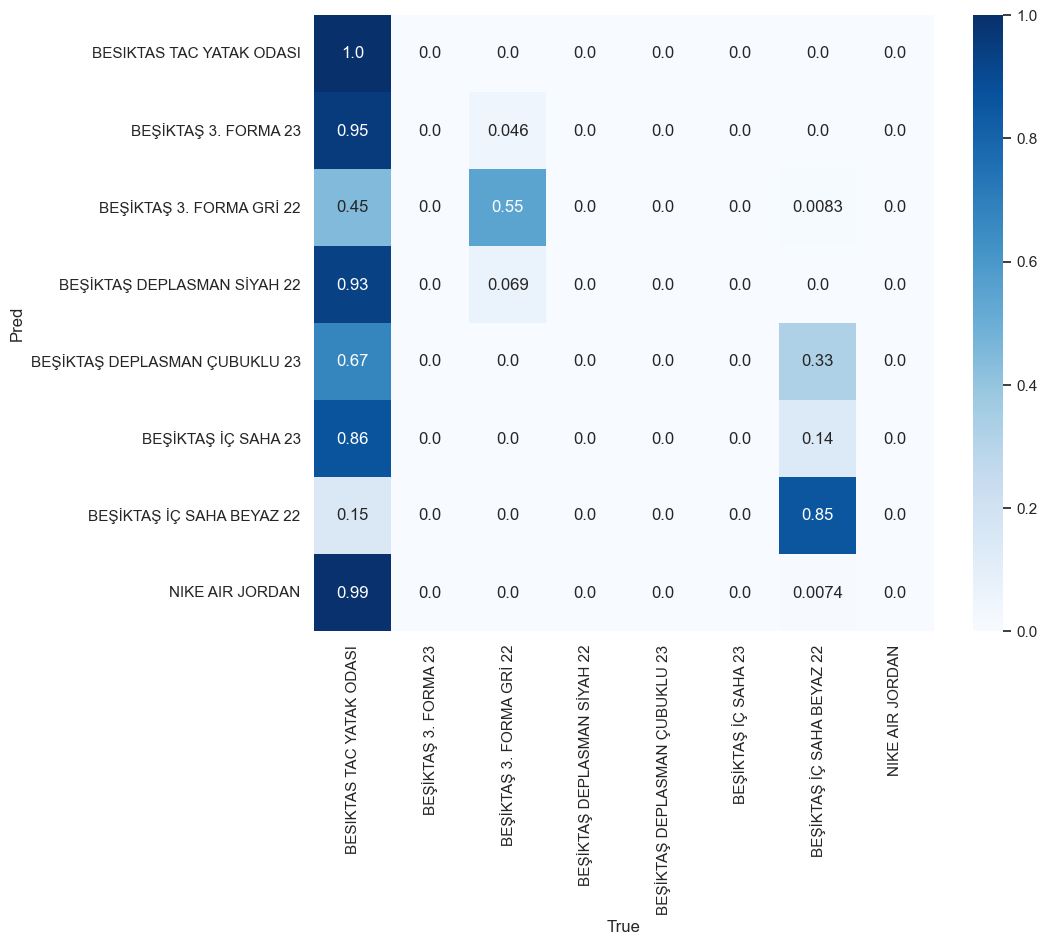

In [31]:
plot_confusion_matrix(y_test,y_pred,le.classes_.tolist())

In [32]:
y_scores = model.predict_proba(X_test)

In [33]:
y_scores

array([[0.  , 0.  , 0.07, ..., 0.06, 0.64, 0.02],
       [0.  , 0.  , 0.03, ..., 0.02, 0.71, 0.02],
       [0.05, 0.39, 0.39, ..., 0.  , 0.04, 0.05],
       ...,
       [0.41, 0.11, 0.14, ..., 0.  , 0.12, 0.14],
       [0.07, 0.01, 0.14, ..., 0.13, 0.4 , 0.02],
       [0.16, 0.17, 0.57, ..., 0.  , 0.  , 0.01]])

In [34]:
y_scores.shape

(1410, 8)

In [35]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

In [36]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
thresholds = dict()
for i in range(le.classes_.shape[0]):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test[:, i], y_scores[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_scores[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test.ravel(), y_scores.ravel()
)
average_precision["micro"] = average_precision_score(y_test, y_scores, average="micro")

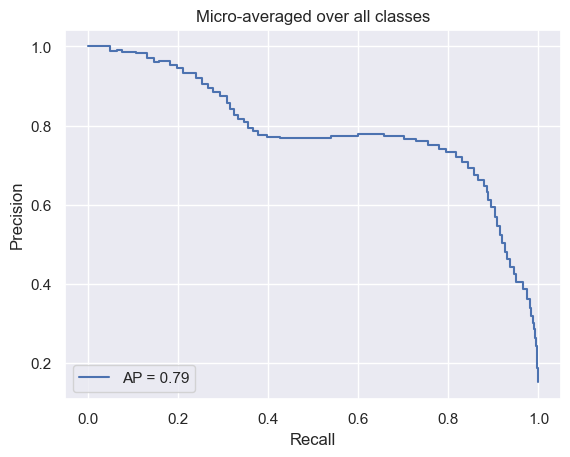

In [37]:
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

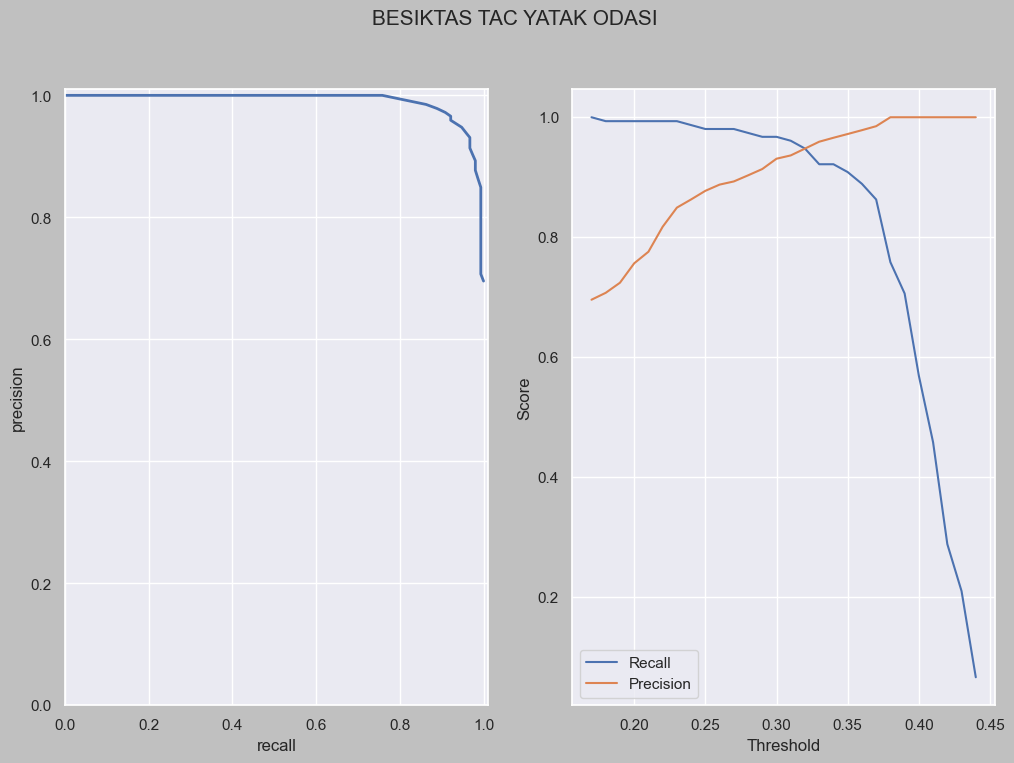

In [38]:
plt.figure(figsize = (12, 8), facecolor = 'silver', edgecolor = 'gray')
plt.subplot(1, 2, 1)
i=0
plt.plot(recall[i], precision[i], lw=2, label='class {}'.format("".join(le.classes_.tolist()[i])))
plt.xlabel('recall')
plt.ylabel('precision')

plt.xlim([0, 1.01])
plt.ylim([0, 1.01])

plt.subplot(1, 2, 2)
plt.plot(thresholds[i], recall[i][:-1], label = "Recall")
plt.plot(thresholds[i], precision[i][:-1], label = "Precision")
plt.xlabel('Threshold')
plt.ylabel('Score')

plt.suptitle(f'{"".join(le.classes_.tolist()[i])}', size = 15 )
    
plt.legend()
plt.savefig('pr.jpeg')
plt.show()

# Cosine Similarity 

In [39]:
from sklearn.metrics.pairwise import cosine_similarity 

In [40]:
df = pd.DataFrame(dataset_list)
examples=dict()
for label in df.label.unique():
    examples[label] = df[df.label==label].feat.iloc[32]
    #idx = np.where(np.array(df.feat.to_list())==examples[label])[0][0]
    #df.drop(index = idx, axis = 1,inplace=True)
    curr = np.array(df[df.label==label].feat.to_list())
    examples[label+'-similarity'] = cosine_similarity(examples[label].reshape(1,curr.shape[1]),curr)


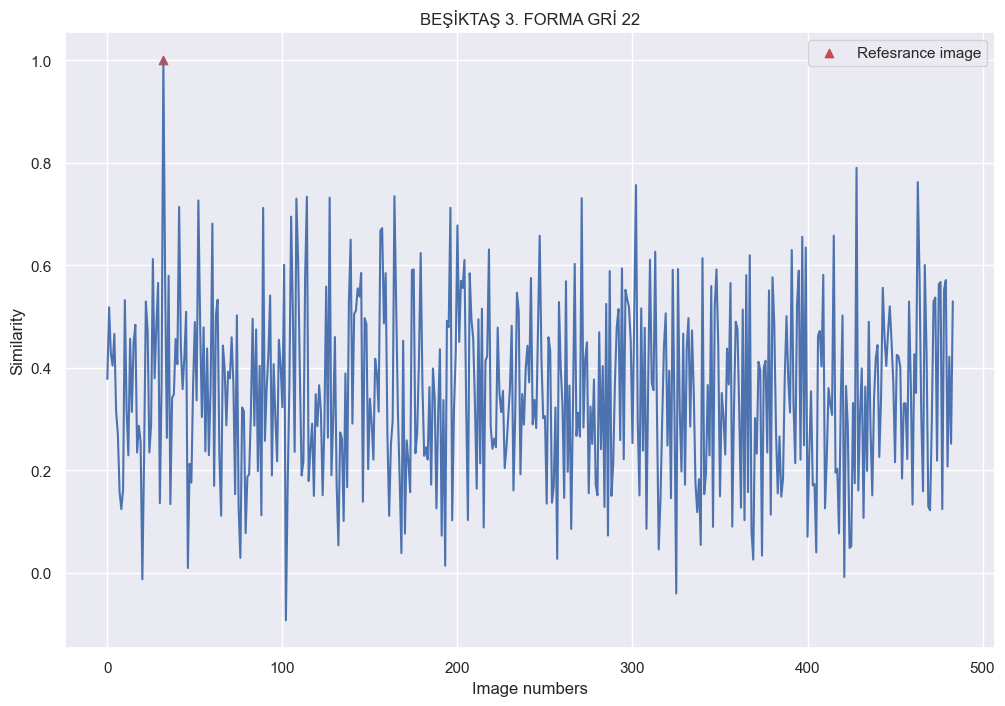

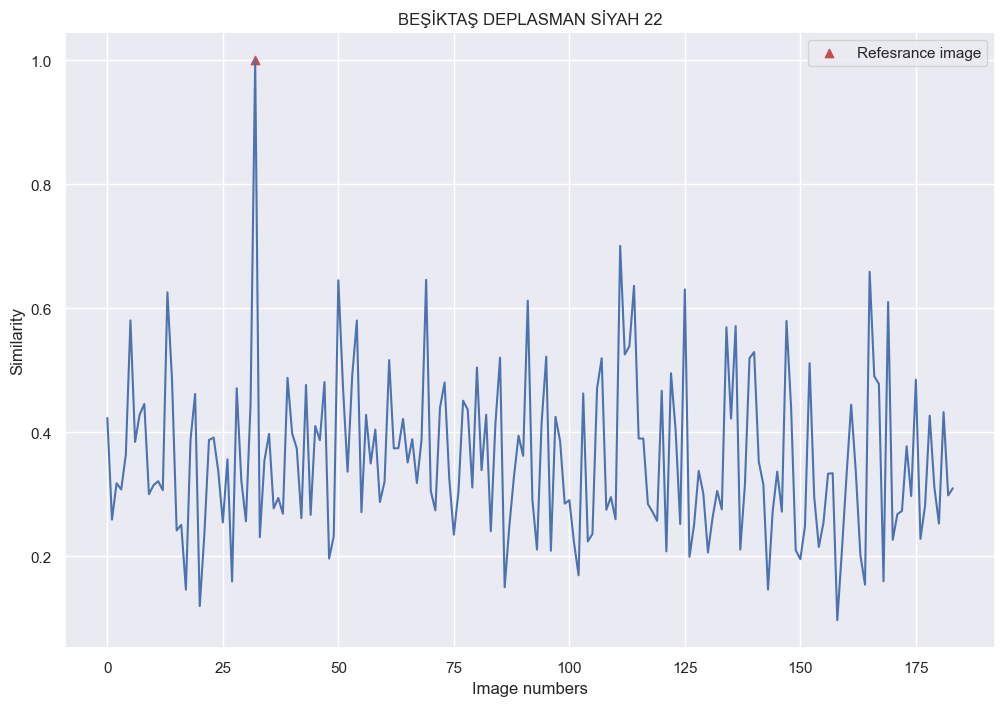

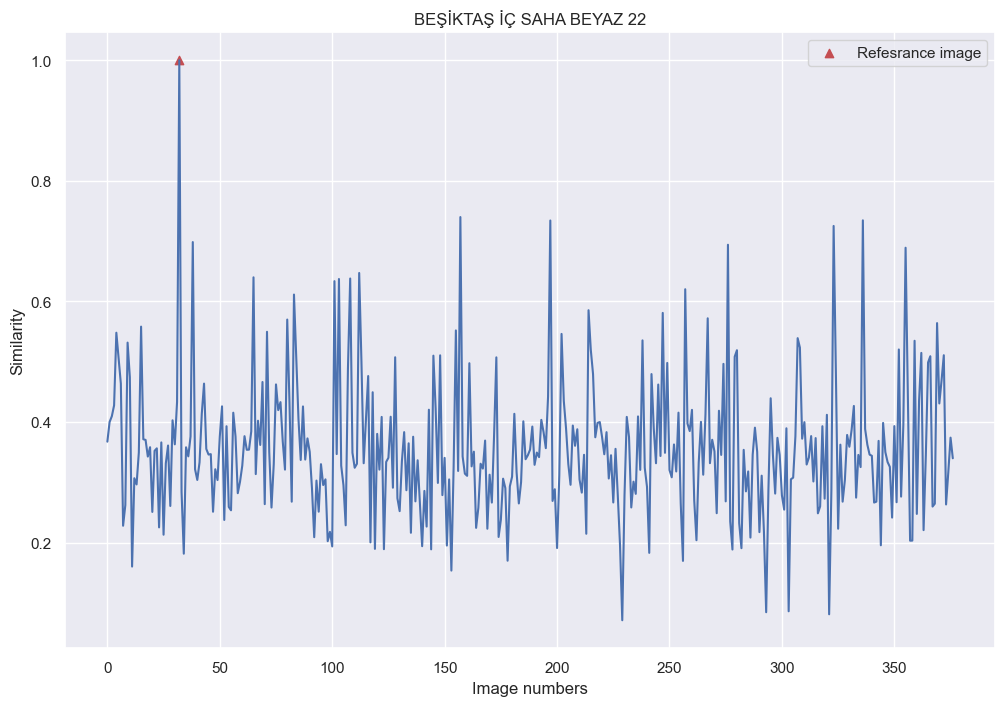

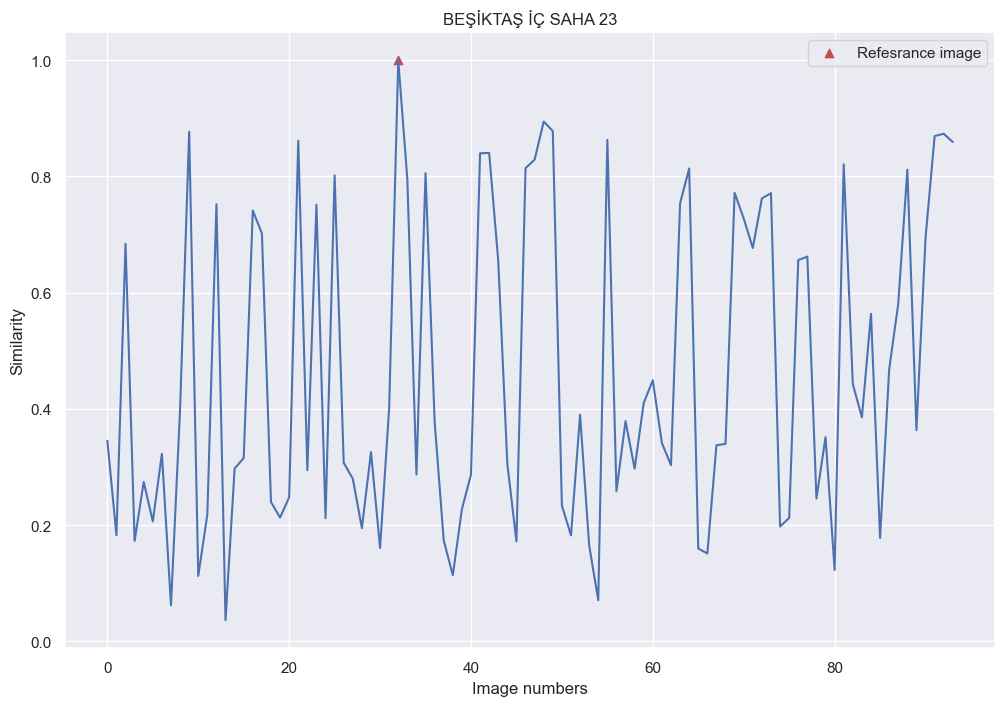

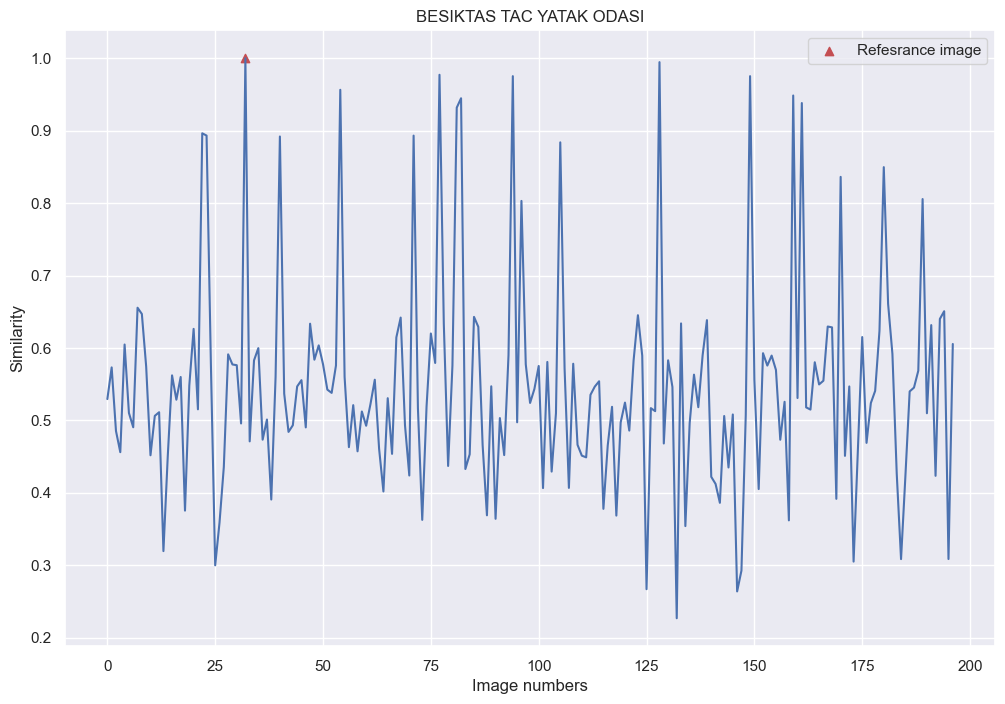

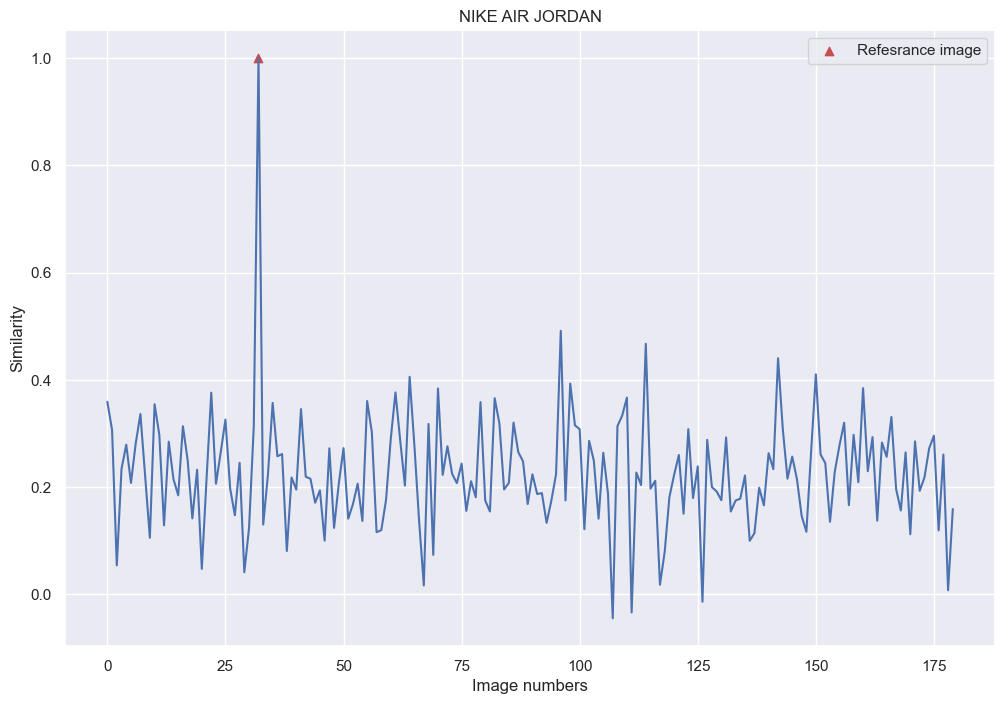

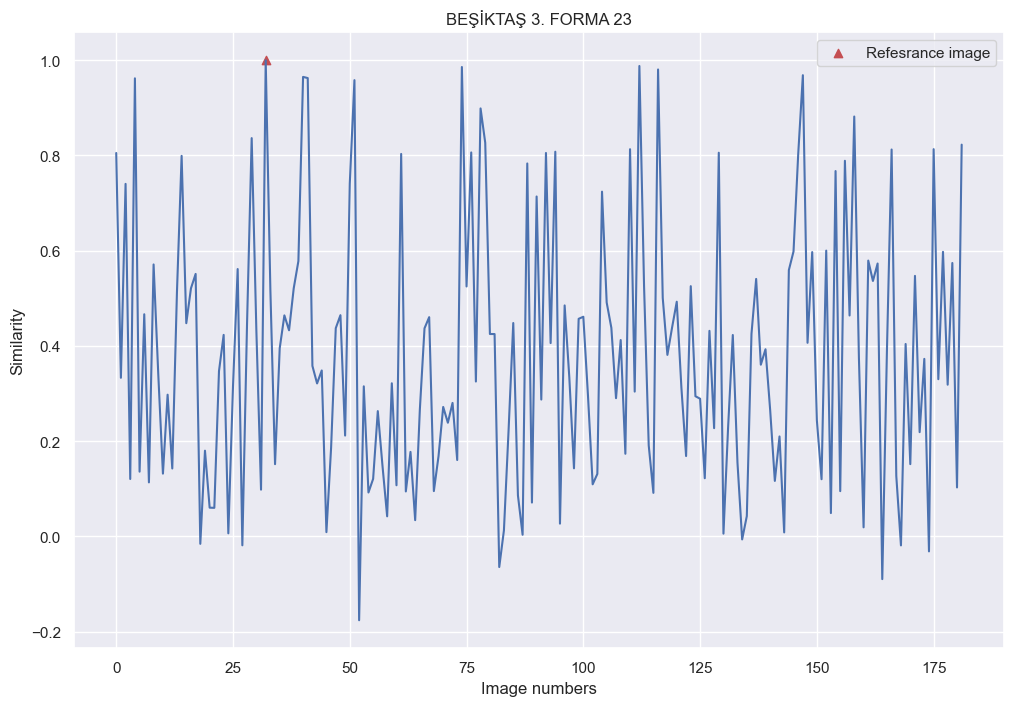

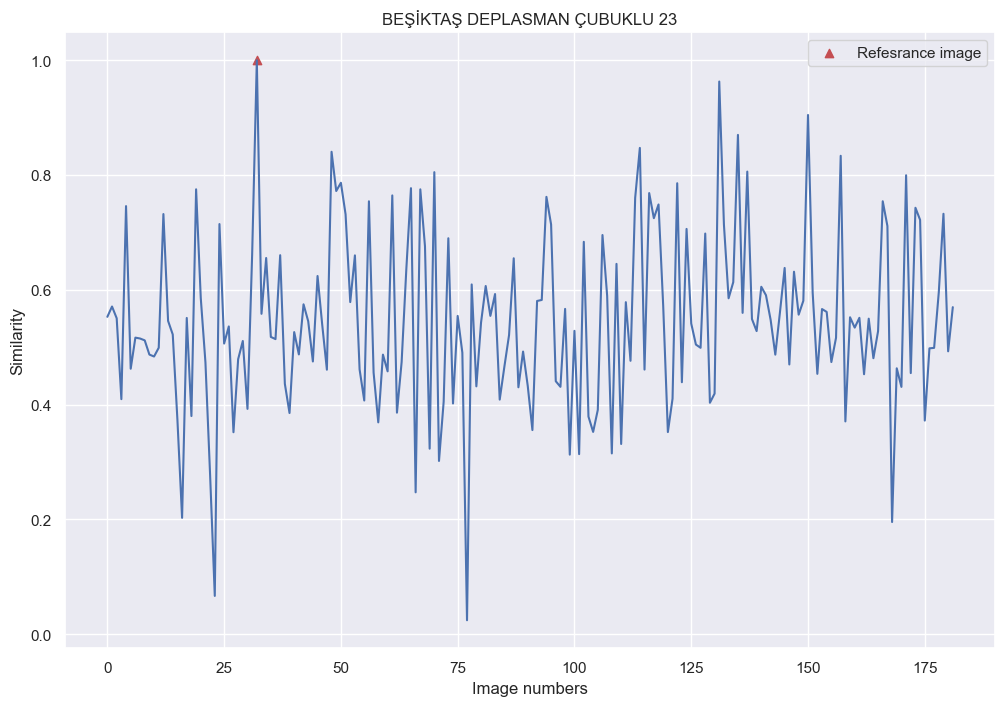

In [41]:
for label in df.label.unique():
    plt.figure(figsize=(12,8))
    plt.plot(examples[label+'-similarity'].reshape(-1,1))
    plt.xlabel('Image numbers')
    plt.ylabel('Similarity')
    plt.scatter(32,1,color = 'r',label='Refesrance image',marker='^')
    plt.title(label)
    plt.legend(loc='best')
    plt.savefig(label+'.jpeg')
    plt.show()

In [42]:
df = pd.DataFrame(dataset_list)

In [43]:
df.label.unique()

array(['BEŞİKTAŞ 3. FORMA GRİ 22', 'BEŞİKTAŞ DEPLASMAN SİYAH 22',
       'BEŞİKTAŞ İÇ SAHA BEYAZ 22', 'BEŞİKTAŞ İÇ SAHA 23',
       'BESIKTAS TAC YATAK ODASI', 'NIKE AIR JORDAN',
       'BEŞİKTAŞ 3. FORMA 23', 'BEŞİKTAŞ DEPLASMAN ÇUBUKLU 23'],
      dtype=object)

# BEŞİKTAŞ DEPLASMAN SİYAH 22 (EXAMPLE CASE)

In [44]:
df_copy = df.copy()

In [45]:
arg_label = 'BEŞİKTAŞ DEPLASMAN SİYAH 22'

In [46]:
df_copy.label = df_copy[df_copy.label != arg_label].label.apply(lambda x : x.replace(x,'0'))

In [47]:
df_copy

,label,feat
0,0,"[0.008667048, 0.024913978, 0.03909646, -0.0167..."
1,0,"[-0.039473504, 0.05063392, -0.050728016, 0.019..."
2,NaN,"[-0.037798513, 0.047292016, 0.08103904, -0.120..."
3,0,"[0.037109666, 0.07035995, 0.015776707, 0.03196..."
4,NaN,"[-0.040597256, 0.0083538545, -0.065146476, -0...."
...,...,...
1875,0,"[-0.068696484, -0.028455034, -0.019603731, 0.0..."
1876,0,"[-0.06349437, -0.029928677, 0.030607479, 0.126..."
1877,0,"[0.031133197, 0.00017002436, 0.056842767, -0.0..."
1878,0,"[-0.0046871416, 0.011687119, -0.108248115, 0.1..."


In [48]:
df_copy.fillna(value=arg_label,inplace=True)

In [49]:
le = LabelEncoder()
labels = le.fit_transform(df_copy.label.values)

In [50]:
referance = df_copy[df_copy.label==arg_label].feat.iloc[32]

In [51]:
pics = np.array(df.feat.tolist())

In [52]:
similarities = cosine_similarity(referance.reshape(1,pics.shape[1]),pics).T

In [53]:
similarities.shape

(1880, 1)

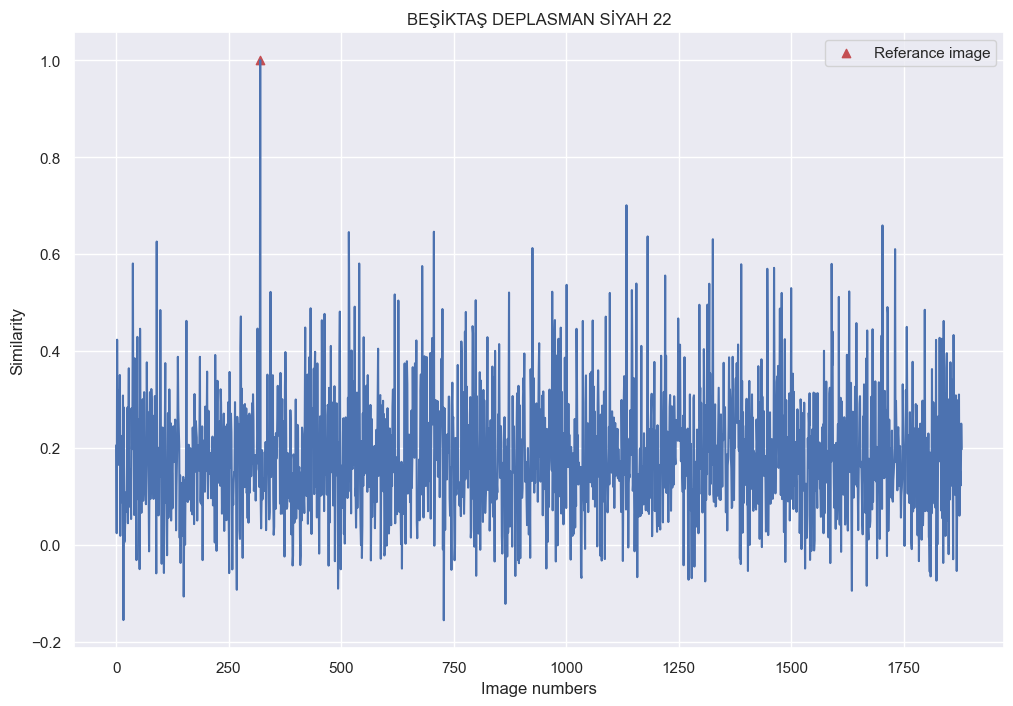

In [54]:
plt.figure(figsize=(12,8))
plt.plot(similarities)
plt.xlabel('Image numbers')
plt.ylabel('Similarity')
plt.scatter(np.where(np.array(df.feat.tolist())==referance)[0][0],1,color = 'r',label='Referance image',marker='^')
plt.title(arg_label)
plt.legend(loc='best')
plt.show()

In [55]:
df_copy.label.unique()

array(['0', 'BEŞİKTAŞ DEPLASMAN SİYAH 22'], dtype=object)

In [56]:
def precision_recall(y_test, y_pred, title = ""):
    global thresholds,recalls,precisions
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)

    plt.figure(figsize = (12, 8), facecolor = 'silver', edgecolor = 'gray')
    plt.subplot(1, 2, 1)
    plt.plot(recalls, precisions)
    plt.xlabel('recall')
    plt.ylabel('precision')

    plt.xlim([0, 1])
    plt.ylim([0, 1])

    plt.subplot(1, 2, 2)
    plt.plot(thresholds, recalls[:-1], label = "Recall")
    plt.plot(thresholds, precisions[:-1], label = "Precision")
    plt.xlabel('Threshold')
    plt.ylabel('Score')

    plt.suptitle(title, size = 15 )
    
    plt.legend()
    plt.savefig('SIMILARITY'+title+'.jpeg')
    plt.show()

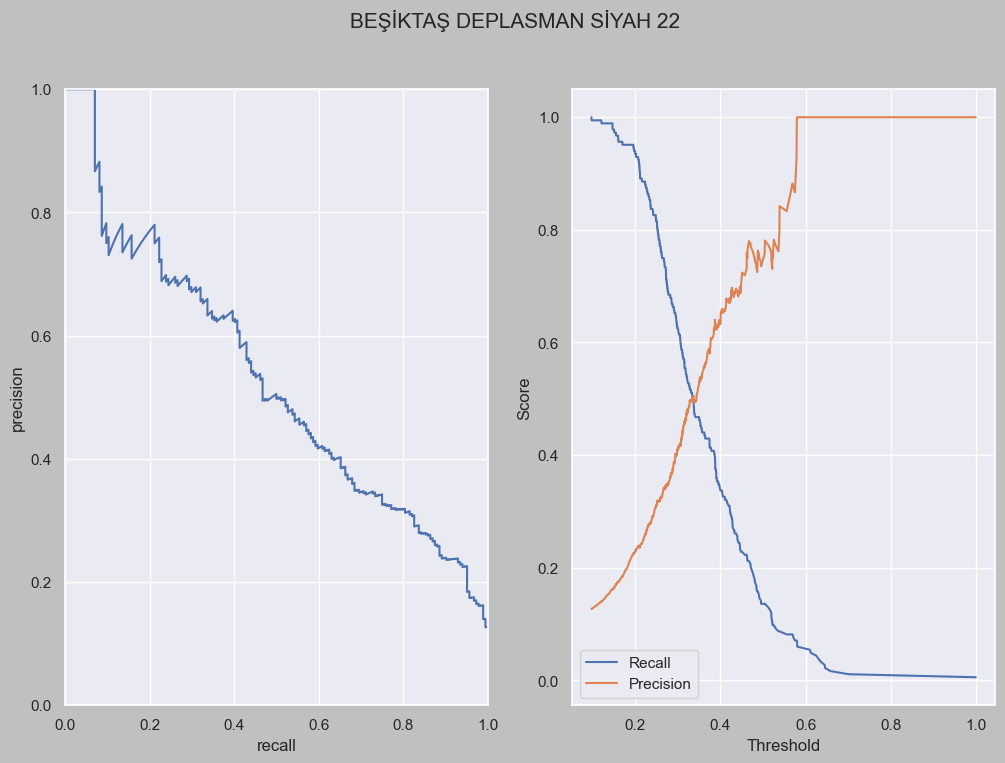

In [57]:
precision_recall(labels,similarities,arg_label)

# SIMILARITY PRECISION RECALL CURVE ON ALL CASES

In [58]:
df = pd.DataFrame(dataset_list)

In [59]:
def get_label(arg_label = ""):
    df_copy = df.copy()
    df_copy.label = df_copy[df_copy.label != arg_label].label.apply(lambda x : x.replace(x,'0'))
    df_copy.fillna(value=arg_label,inplace=True)
    le = LabelEncoder()
    labels = le.fit_transform(df_copy.label.values)
    return labels 

In [60]:
def get_similarity(arg_label):
    df_copy = df.copy()
    referance = df_copy[df_copy.label==arg_label].feat.iloc[32]
    pics = np.array(df.feat.tolist())
    similarities = cosine_similarity(referance.reshape(1,pics.shape[1]),pics).T
    return similarities

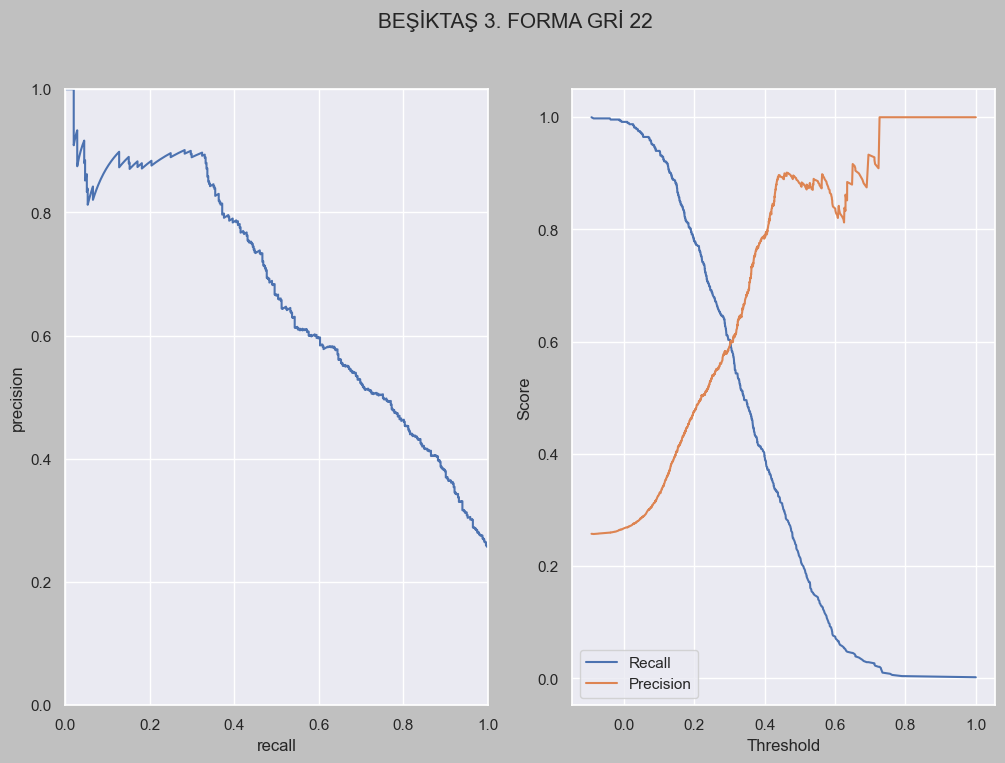

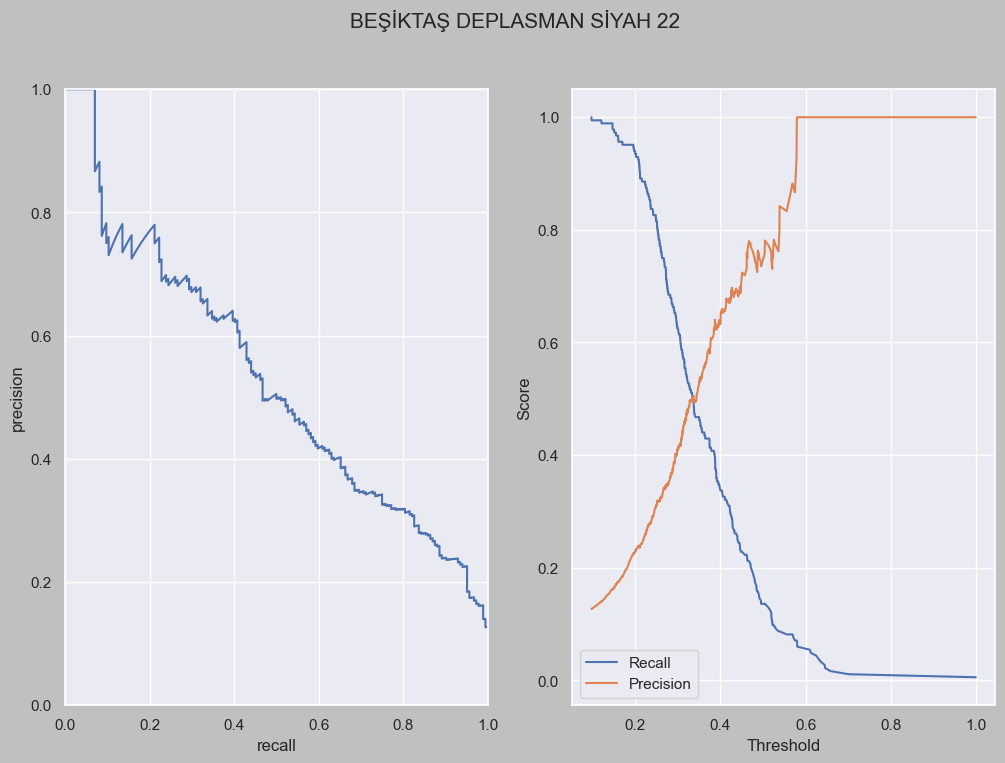

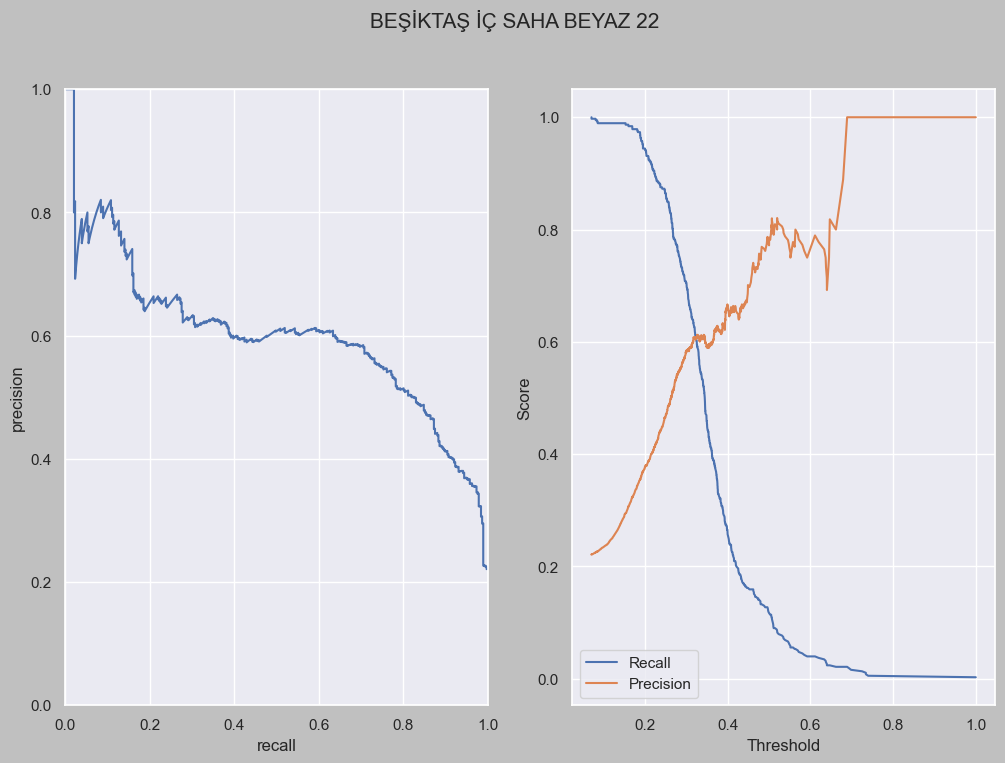

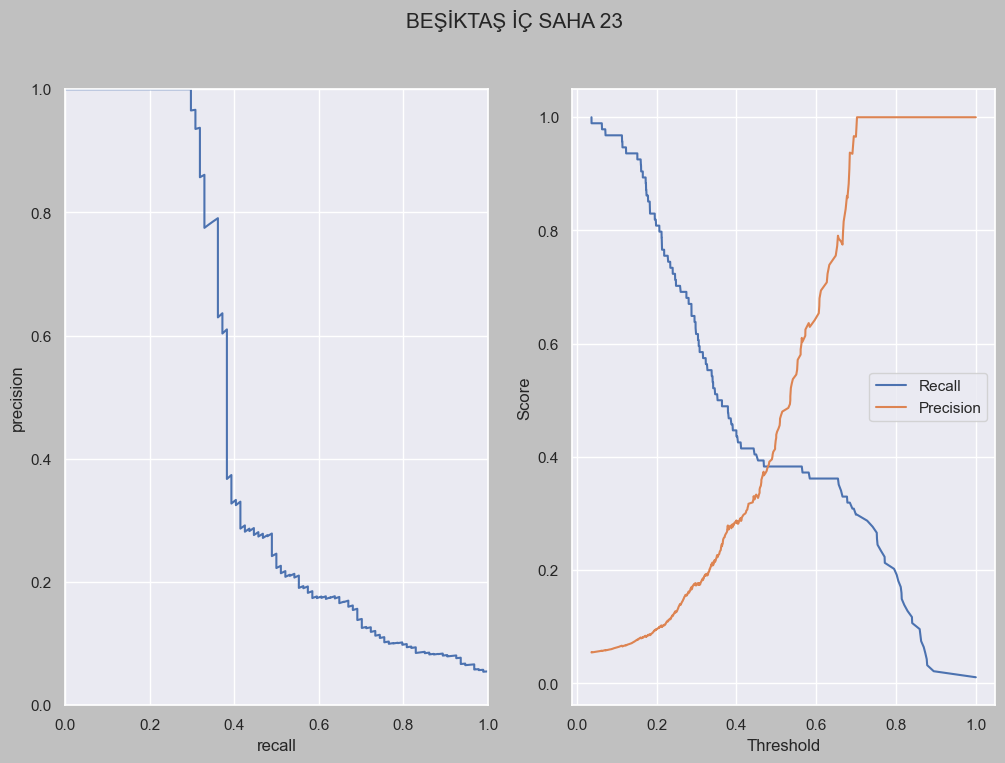

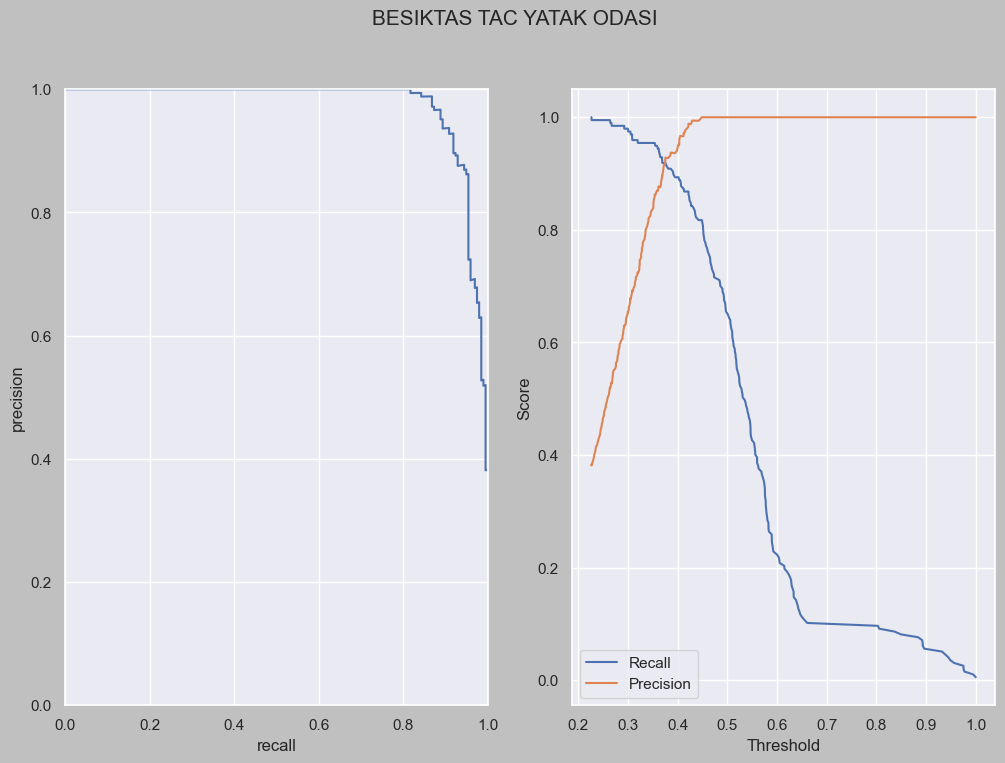

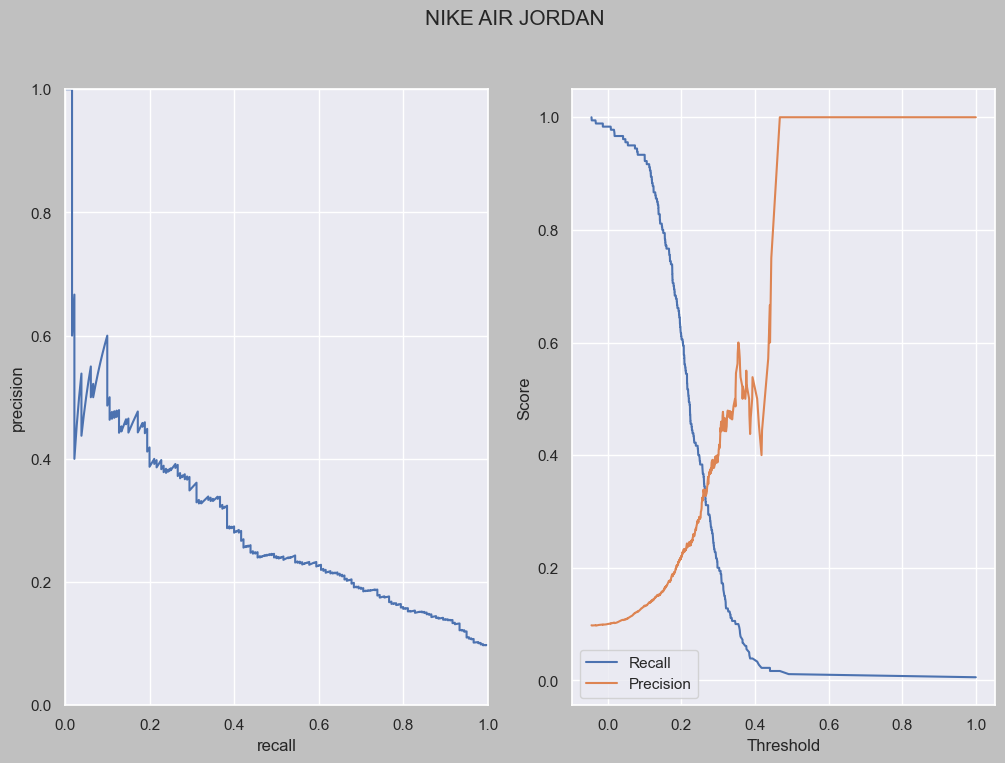

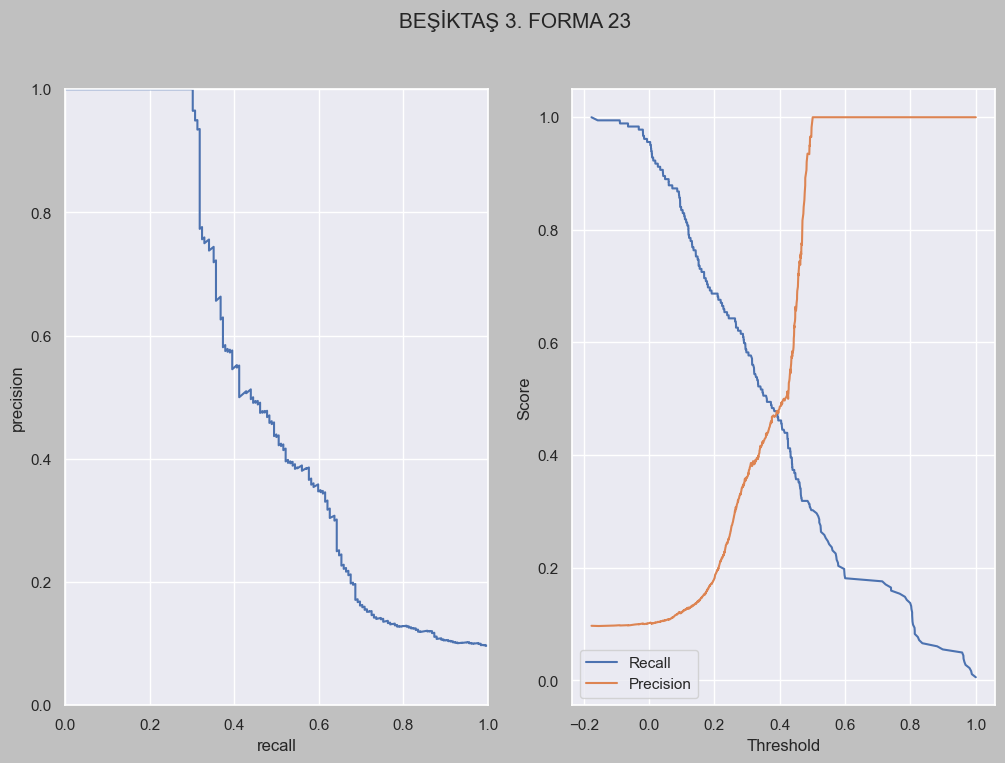

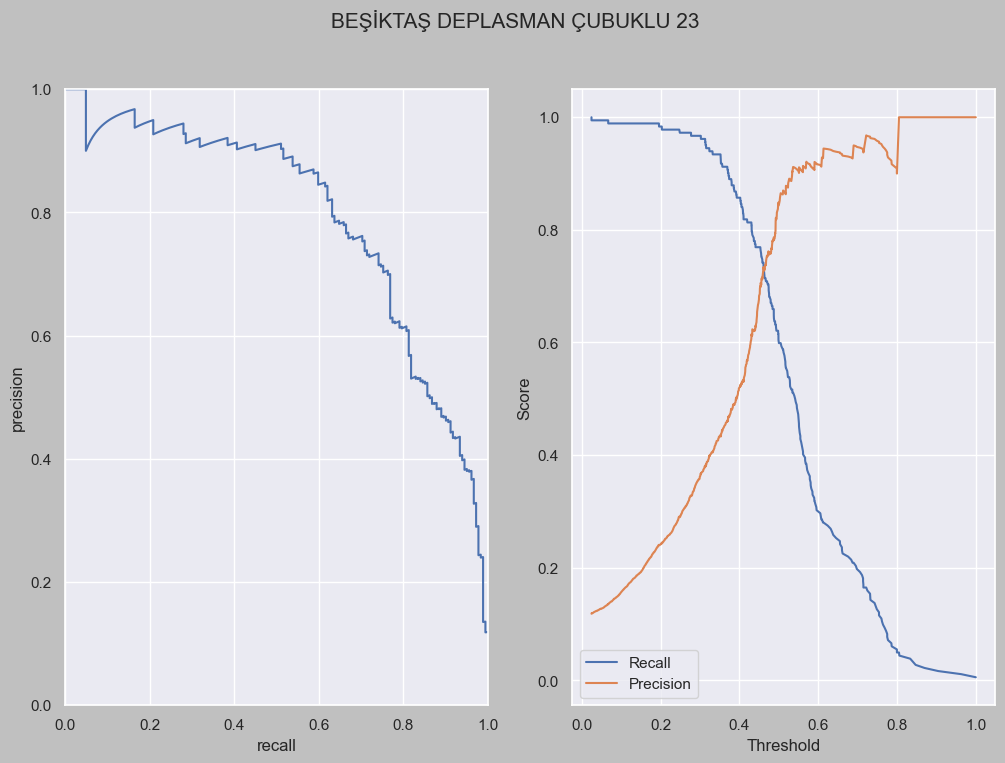

In [61]:
for arg_label in df.label.unique():
    labels = get_label(arg_label)
    similarities = get_similarity(arg_label)
    precision_recall(labels,similarities,arg_label)

# K-MEANS CLUSTERING 

In [62]:
from sklearn.cluster import KMeans

In [63]:
X = np.array(df.feat.to_list())

In [64]:
le = LabelEncoder()

In [65]:
y = le.fit_transform(df.label.values)

In [66]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [67]:
le.classes_

array(['BESIKTAS TAC YATAK ODASI', 'BEŞİKTAŞ 3. FORMA 23',
       'BEŞİKTAŞ 3. FORMA GRİ 22', 'BEŞİKTAŞ DEPLASMAN SİYAH 22',
       'BEŞİKTAŞ DEPLASMAN ÇUBUKLU 23', 'BEŞİKTAŞ İÇ SAHA 23',
       'BEŞİKTAŞ İÇ SAHA BEYAZ 22', 'NIKE AIR JORDAN'], dtype=object)

Text(0.5, 1.0, 'All Data with Clusters Colored')

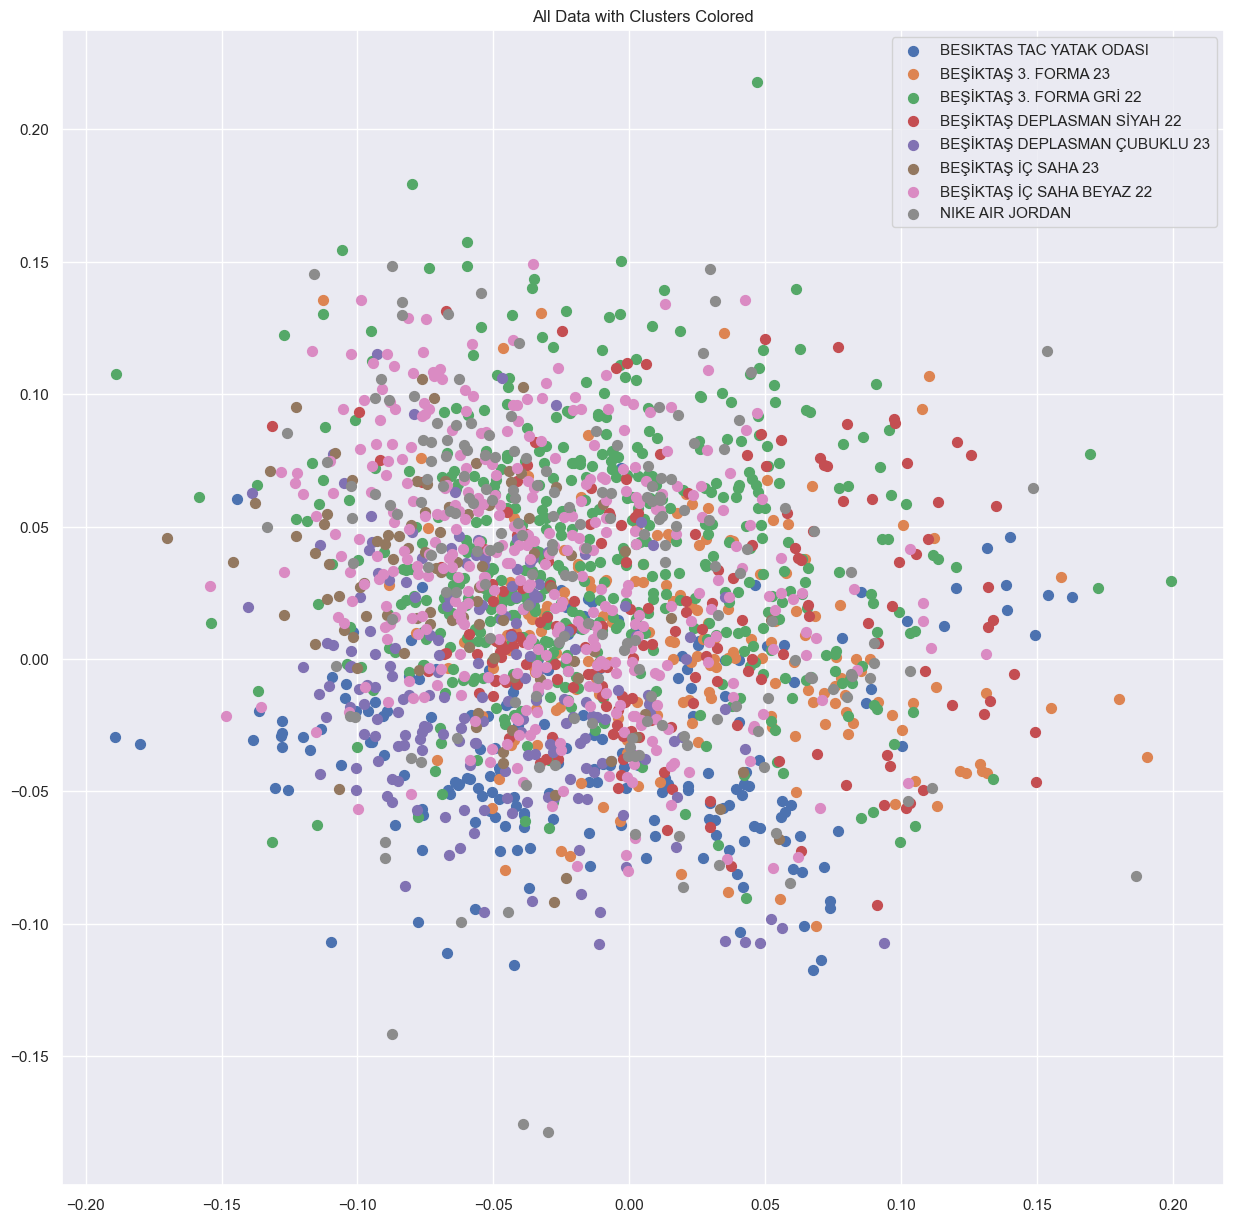

In [68]:
fig=plt.figure(figsize=(15,15))
plt.scatter(X[y == 0, 0], X[y == 0, 1], s=50, label=le.classes_[0])
plt.scatter(X[y == 1, 0], X[y == 1, 1], s=50, label=le.classes_[1])
plt.scatter(X[y == 2, 0], X[y == 2, 1], s=50, label=le.classes_[2])
plt.scatter(X[y == 3, 0], X[y == 3, 1], s=50, label=le.classes_[3])
plt.scatter(X[y == 4, 0], X[y == 4, 1], s=50, label=le.classes_[4])
plt.scatter(X[y == 5, 0], X[y == 5, 1], s=50, label=le.classes_[5])
plt.scatter(X[y == 6, 0], X[y == 6, 1], s=50, label=le.classes_[6])
plt.scatter(X[y == 7, 0], X[y == 7, 1], s=50, label=le.classes_[7])
plt.legend()
plt.title('All Data with Clusters Colored')

In [69]:
model = KMeans(n_clusters=df.label.nunique(),random_state=42,init='k-means++')

In [70]:
model.fit(X)

KMeans(random_state=42)

In [71]:
model.cluster_centers_

array([[-0.02238699,  0.0331189 ,  0.08693887, ..., -0.06272409,
         0.10662488, -0.04966504],
       [ 0.01060322,  0.04011435, -0.01586547, ..., -0.02873707,
         0.03429208, -0.01200589],
       [-0.01641733, -0.03435743, -0.01097465, ..., -0.04015566,
         0.06714325,  0.0076186 ],
       ...,
       [-0.0173145 ,  0.00413028,  0.05860139, ..., -0.08460517,
        -0.02872061, -0.02023023],
       [ 0.02081483,  0.0023685 , -0.0727612 , ...,  0.03824732,
        -0.00684107, -0.0939396 ],
       [-0.03133431,  0.03834805,  0.0150316 , ..., -0.03325685,
         0.04888109,  0.04302859]], dtype=float32)

In [72]:
ypred = model.predict(X)

In [73]:
ypred

array([1, 1, 1, ..., 5, 1, 1], dtype=int32)

In [76]:
model.cluster_centers_.shape

(8, 192)

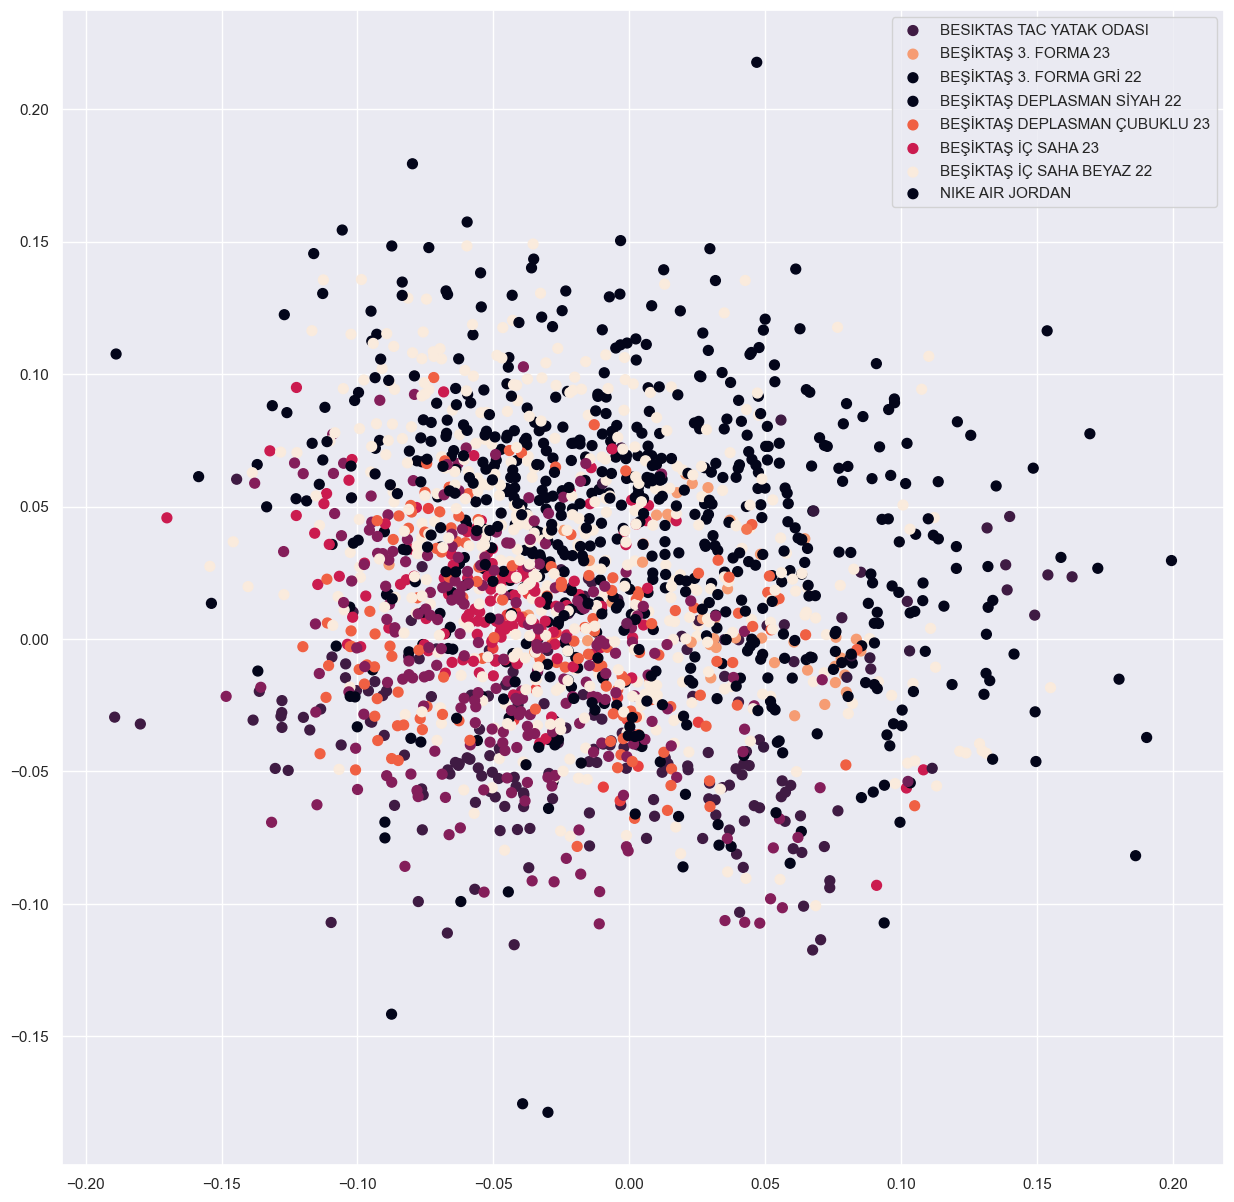

In [75]:
plt.figure(figsize=(15,15))
plt.scatter(X[y == 0, 0], X[y == 0, 1], s=50, label=le.classes_[0],c=ypred[y==0])
plt.scatter(X[y == 1, 0], X[y == 1, 1], s=50, label=le.classes_[1],c=ypred[y==1])
plt.scatter(X[y == 2, 0], X[y == 2, 1], s=50, label=le.classes_[2],c=ypred[y==2])
plt.scatter(X[y == 3, 0], X[y == 3, 1], s=50, label=le.classes_[3],c=ypred[y==3])
plt.scatter(X[y == 4, 0], X[y == 4, 1], s=50, label=le.classes_[4],c=ypred[y==4])
plt.scatter(X[y == 5, 0], X[y == 5, 1], s=50, label=le.classes_[5],c=ypred[y==5])
plt.scatter(X[y == 6, 0], X[y == 6, 1], s=50, label=le.classes_[6],c=ypred[y==6])
plt.scatter(X[y == 7, 0], X[y == 7, 1], s=50, label=le.classes_[7],c=ypred[y==7])
plt.legend()
plt.savefig('cluster.jpeg')

# TSNE Graph

In [231]:
X = np.array(df['feat'].to_list())
X = np.reshape(X, (X.shape[0], -1))

X_tsne = TSNE(verbose = 1, random_state = 42).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1880 samples in 0.001s...
[t-SNE] Computed neighbors for 1880 samples in 0.084s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1880
[t-SNE] Computed conditional probabilities for sample 1880 / 1880
[t-SNE] Mean sigma: 0.364872
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.227173
[t-SNE] KL divergence after 1000 iterations: 0.800542


(-75.0, 75.0)

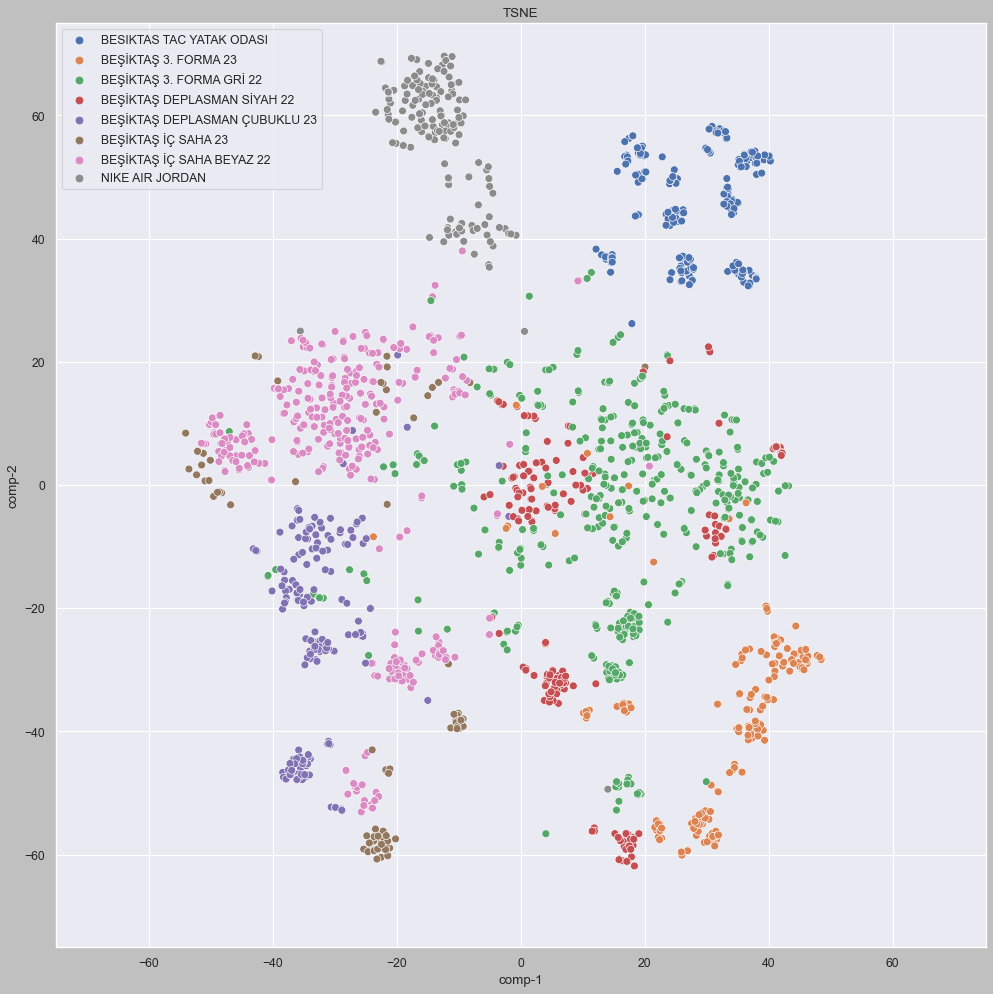

In [232]:
df["comp-1"] = X_tsne[:,0]
df["comp-2"] = X_tsne[:,1]

plt.figure(figsize = (15, 15), dpi = 80, facecolor = 'silver', edgecolor = 'gray')

sns.scatterplot(x = "comp-1", y = "comp-2", 
                hue = "label", s = 50,
                hue_order = classes,
                palette = "deep",
                data = df).set(title = "TSNE")

plt.legend(loc = 'upper left')
plt.xlim([-75, 75])
plt.ylim([-75, 75])